In [1]:
import matplotlib.pyplot as plt
from utils import QUtils, QUtilsSorted, unflatten
from tqdm import trange
from os.path import join
import numpy as np
import yaml
from warnings import warn
import h5py
import pickle
import random
import os
import time


def general_triu_inverse(x: np.ndarray, N: int, n_diagonal: int = 0) -> np.ndarray:
    """
    Converts flattened upper-triangular matrices with zero off-diagonal terms into full
    symmetric matrices.

    Parameters
    ----------
    x: np.ndarray
        Flattened matrices of size (length, -1) or matrix of size (-1,)
    N: int
        Size of the N * N matrix
    n_diagonal: int
        Number of off-diagonal terms that are set to 0

    Returns
    -------
    mat: np.ndarray
        Array of shape (length, N, N) or (N, N)
    """
    if x.ndim == 1:
        mat = np.zeros((N, N))
    else:
        mat = np.zeros((x.shape[0], N, N))
    list_indices = list(zip(*np.triu_indices(N, k=1)))
    list_indices = [i for i in list_indices if np.abs(i[0] - i[1]) > n_diagonal]
    a = np.array([i[0] for i in list_indices])
    b = np.array([i[1] for i in list_indices])
    mat[..., a, b] = x
    mat += mat.swapaxes(-2, -1)
    return mat

/home/koubape9/.conda/envs/tf/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [27]:
#load .npy's
from collections import defaultdict
SYSTEMS = ['ZS-ab2','ZS-ab3','ZS-ab4']
FRAMES_PER_SPLIT = 5
SPLITS = 2000

grads = defaultdict(list)
classifications = defaultdict(list)

for system in SYSTEMS:
    for split in range(SPLITS):
        path_grad = '{}_grads_{}_job_{}.npy'.format(system,FRAMES_PER_SPLIT,split)
        path_clas = '{}_classification_{}_job_{}.npy'.format(system,FRAMES_PER_SPLIT,split)
        grad_part = np.load(path_grad)
        clas_part = np.load(path_clas)
        grads[system].append(grad_part)
        classifications[system].append(clas_part)
    grads[system] = np.concatenate(grads[system],axis=2)
    classifications[system] = np.concatenate(classifications[system],axis=2)

In [31]:
#TESTING
model_averaged_class_scores = {system: class_scores.mean(0) for system, class_scores in classifications.items()}
print(model_averaged_class_scores['ZS-ab2'].shape)
s = model_averaged_class_scores['ZS-ab2']
idcs = np.argmax(s,axis=0)
sum(idcs == 2)

(3, 10000)


156

In [46]:
#TODO: Apply the sorts (both local and between systems) here!
local_sort_path = 'local_sorters.yml'
global_sort_path = 'system_sorters.yml'
with open(local_sort_path, "r") as read:
    local_sorters = yaml.safe_load(read)

with open(global_sort_path, "r") as read:
    global_sorters = yaml.safe_load(read)

#concatenate sorters
composed_sorters = {system: np.empty((20,3)) for system in SYSTEMS}

for system in SYSTEMS:
    for i in range(20):
        composed_sorters[system][i] = np.array(local_sorters[system][i], dtype='int')[global_sorters[system]]


In [47]:
#TESTING
print("composed sorter {}".format(composed_sorters['ZS-ab2'])) #THERE IS THE BUG
print("local sorter {}".format(local_sorters['ZS-ab2'])) #THERE IS THE BUG
print("global sorter {}".format(global_sorters['ZS-ab2'])) #THERE IS THE BUG

composed sorter [[1. 2. 0.]
 [1. 2. 0.]
 [0. 2. 1.]
 [0. 1. 2.]
 [1. 0. 2.]
 [0. 2. 1.]
 [2. 0. 1.]
 [0. 1. 2.]
 [1. 0. 2.]
 [1. 0. 2.]
 [1. 0. 2.]
 [1. 0. 2.]
 [0. 2. 1.]
 [2. 0. 1.]
 [1. 0. 2.]
 [0. 1. 2.]
 [1. 0. 2.]
 [0. 1. 2.]
 [0. 2. 1.]
 [1. 0. 2.]]
local sorter [[1, 2, 0], [1, 2, 0], [0, 2, 1], [0, 1, 2], [1, 0, 2], [0, 2, 1], [2, 0, 1], [0, 1, 2], [1, 0, 2], [1, 0, 2], [1, 0, 2], [1, 0, 2], [0, 2, 1], [2, 0, 1], [1, 0, 2], [0, 1, 2], [1, 0, 2], [0, 1, 2], [0, 2, 1], [1, 0, 2]]
global sorter [0, 1, 2]


In [49]:
grads_sorted = {system: np.empty((20,3,10000,780)) for system in SYSTEMS}
class_sorted = {system: np.empty((20,3,10000)) for system in SYSTEMS}
for system in SYSTEMS:
    for i in range(20):
        grads_sorted[system][i] = grads[system][i][composed_sorters[system][i].astype('int')].copy() ################TODO: check that the alignment is applied here
        class_sorted[system][i] = classifications[system][i][composed_sorters[system][i].astype('int')].copy() ################TODO: check that the alignment is applied here

In [50]:
#TESTING
model_averaged_class_scores = {system: class_sorted[system].mean(0) for system, class_scores in classifications.items()}
print(model_averaged_class_scores['ZS-ab2'].shape)
s = model_averaged_class_scores['ZS-ab2']
idcs = np.argmax(s,axis=0)
sum(idcs == 0)

(3, 10000)


2274

In [53]:
CLASSES = (0,1,2)
model_averaged_grads = {system: value.mean(0) for system, value in grads_sorted.items()} # {system: value.mean(0) for system, value in grads.items()} #NO SORT
model_averaged_class_scores = {system: class_scores.mean(0) for system, class_scores in class_sorted.items()} # {system: class_scores.mean(0) for system, class_scores in classifications.items()} #NO SORT
#debugger testing: 2v4   -> ZSab2 global sorter: [1,2,0]
#                  2v3     -> ZSab2 global_sorter: [2,0,1]
#system_sorter 2v3 [2, 1, 0] vs system_sorter 2v4 [0, 1, 2] ???
#global_sorter==system_sorter 2v3: [2, 0, 1]
#global_sorter==system_sorter 2v4: [0, 2, 1]
model_averaged_grads[system].shape

(3, 10000, 780)

In [54]:
gs_per_system = {}
gs_per_system_pooled = {}
for system in SYSTEMS:
    s = model_averaged_class_scores[system]
    idcs = np.argmax(s,axis=0)
    g_00 = model_averaged_grads[system][0,np.where(idcs==0),:].mean(axis=1)
    g_01 = model_averaged_grads[system][0,np.where(idcs==1),:].mean(axis=1)
    g_02 = model_averaged_grads[system][0,np.where(idcs==2),:].mean(axis=1)
    g_10 = model_averaged_grads[system][1,np.where(idcs==0),:].mean(axis=1)
    g_11 = model_averaged_grads[system][1,np.where(idcs==1),:].mean(axis=1)
    g_12 = model_averaged_grads[system][1,np.where(idcs==2),:].mean(axis=1)
    g_20 = model_averaged_grads[system][2,np.where(idcs==0),:].mean(axis=1)
    g_21 = model_averaged_grads[system][2,np.where(idcs==1),:].mean(axis=1)
    g_22 = model_averaged_grads[system][2,np.where(idcs==2),:].mean(axis=1)
    g_pooled_0 = model_averaged_grads[system][0,:,:].reshape(1,10000,-1).mean(axis=1)
    g_pooled_1 = model_averaged_grads[system][1,:,:].reshape(1,10000,-1).mean(axis=1)
    g_pooled_2 = model_averaged_grads[system][2,:,:].reshape(1,10000,-1).mean(axis=1)
    print('shape of g00 = {} shape of g0 = {}'.format(model_averaged_grads[system][0].shape,model_averaged_grads[system][0,:,:].shape))
    gs = [[g_00,g_01, g_02],[g_10,g_11, g_12],[g_20,g_21, g_22]]
    print(g_pooled_0.shape) #TODO
    gs_per_system[system] = gs
#     gs_per_system_pooled[system] = [g_pooled_0.reshape(-1,1),g_pooled_1.reshape(-1,1),g_pooled_2.reshape(-1,1)]
    gs_per_system_pooled[system] = [g_pooled_0,g_pooled_1,g_pooled_2]

shape of g00 = (10000, 780) shape of g0 = (10000, 780)
(1, 780)
shape of g00 = (10000, 780) shape of g0 = (10000, 780)
(1, 780)
shape of g00 = (10000, 780) shape of g0 = (10000, 780)
(1, 780)


# Visualize full matrix of plots

System = ZS-ab2


/home/koubape9/.conda/envs/tf/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


System = ZS-ab3
System = ZS-ab4


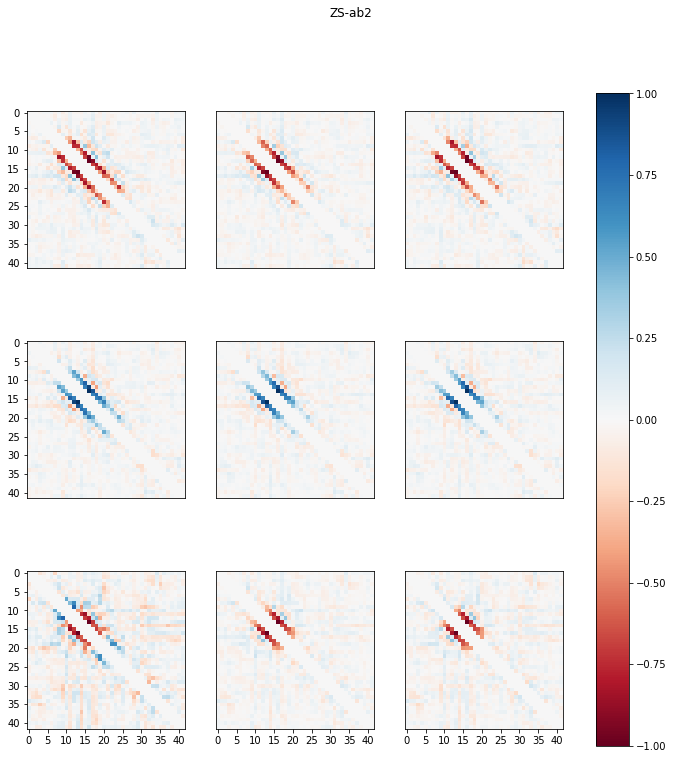

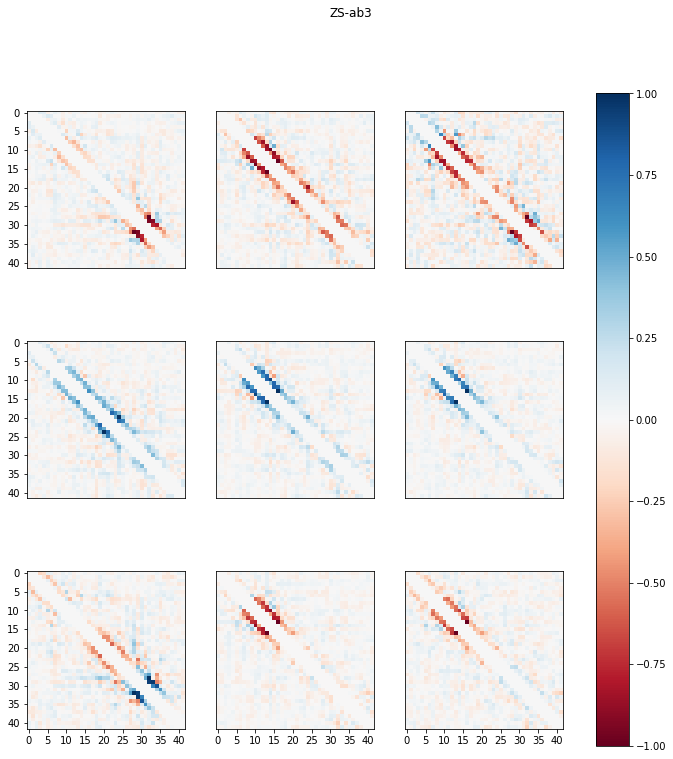

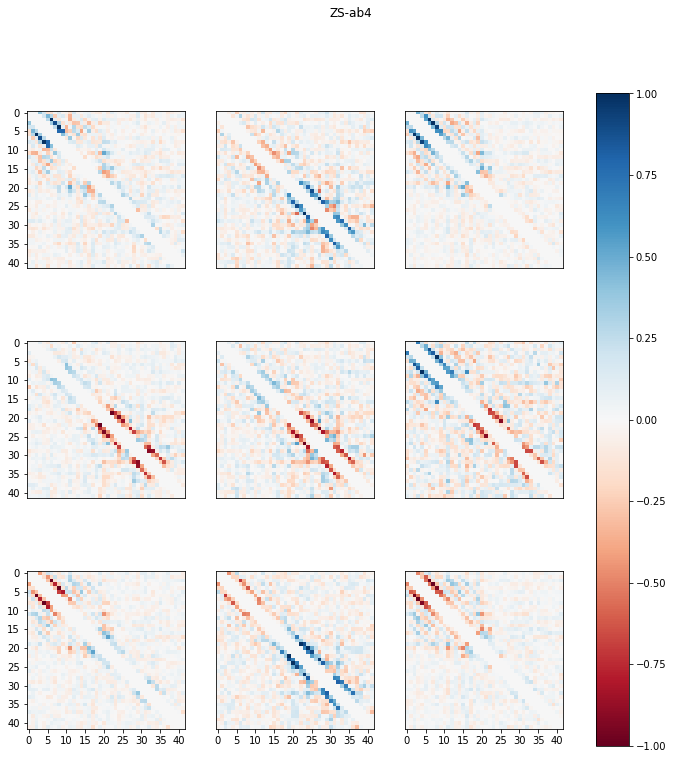

In [57]:
### TODO: create variant of averaging using the class_scores as weights (per attempt)

# Visualize
#TODO
for system in SYSTEMS:
    g = gs_per_system[system]
    fig, ax = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)
    fig.suptitle(system)
    print('System = {}'.format(system))
    for c_row in CLASSES:
        for c_col in CLASSES:
            # scores = model_averaged_class_scores[system]
            # TODO: prepare the grid for the plots
            # TODO: apply the alignment once settled (mind the randomness coming from k-means init
            sup_norm = np.abs(g[c_row][c_col]).max()
            pcm = ax[c_row,c_col].matshow(general_triu_inverse(g[c_row][c_col][0,:] / sup_norm, 42, n_diagonal=2), cmap="RdBu", vmin=-1,vmax=1)
#             print('Row {}, Col {}, max value = {:.5f}'.format(c_row,c_col,(g[c_row][c_col]).max()))
#             print('Row {}, Col {}, min value = {:.5f}'.format(c_row,c_col,(g[c_row][c_col]).min()))
            if (c_col > 0) and (c_row < 2):
                ax[c_row,c_col].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left='off',      # ticks along the bottom edge are off
                    right='off',         # ticks along the top edge are off
                    bottom='off',
                    top='off',
                    labelbottom='off',  # labels along the bottom edge are off)
                    labelleft='off'
                )
            elif (c_col > 0) and (c_row == 2):
                ax[c_row,c_col].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left='off',      # ticks along the bottom edge are off
                    right='off',         # ticks along the top edge are off
                    bottom='on',
                    top='off',
                    labelbottom='on',  # labels along the bottom edge are off)
                    labelleft='off',
                    labeltop='off'
                )
            elif (c_col == 0) and (c_row < 2):
                ax[c_row,c_col].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left='on',      # ticks along the bottom edge are off
                    right='off',         # ticks along the top edge are off
                    bottom='off',
                    top='off',
                    labelbottom='off',  # labels along the bottom edge are off)
                    labelleft='on'
                )
            elif (c_col == 0) and (c_row == 2):
                ax[c_row,c_col].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left='on',      # ticks along the bottom edge are off
                    bottom='on',
                    right='off',         # ticks along the top edge are off
                    top='off',
                    labelbottom='on',  # labels along the bottom edge are off)
                    labelleft='on',
                    labeltop='off'
                )
    fig.colorbar(pcm,ax=ax)
    plt.savefig('{}_saliency_full.png'.format(system), dpi=600)

# Visualize plots pooled over all frames

System = ZS-ab2
(1, 780)
(1, 780)
(1, 780)


/home/koubape9/.conda/envs/tf/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


System = ZS-ab3
(1, 780)
(1, 780)
(1, 780)
System = ZS-ab4
(1, 780)
(1, 780)
(1, 780)


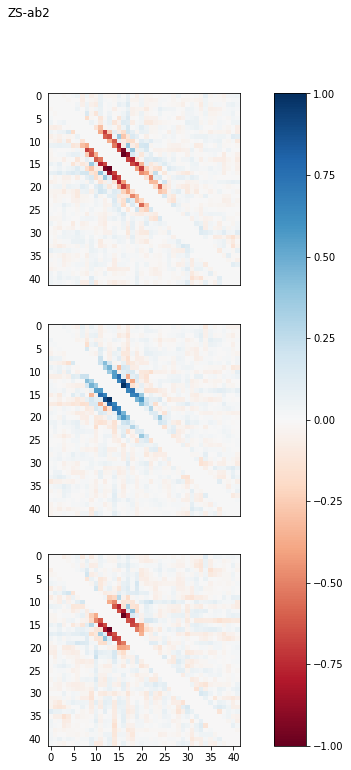

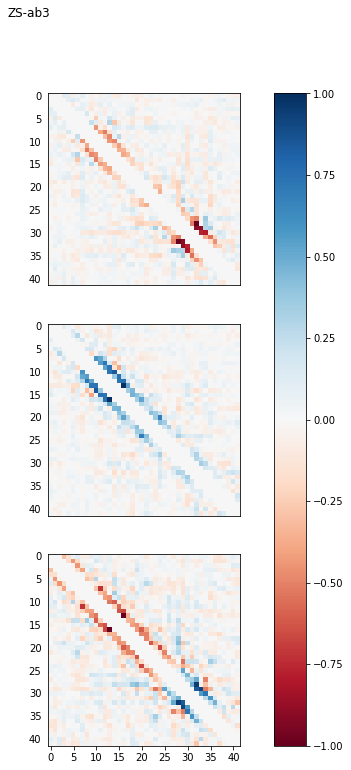

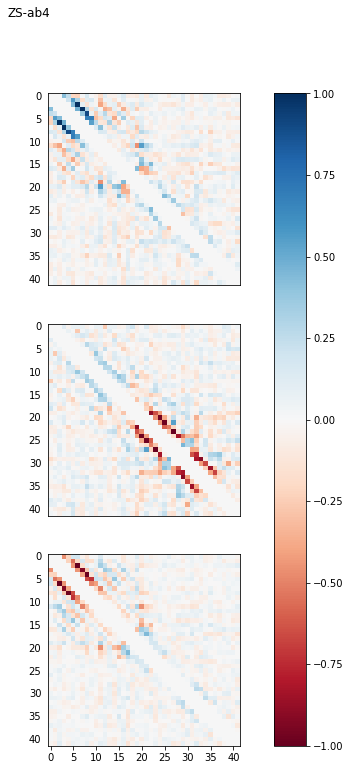

In [58]:
### TODO: create variant of averaging using the class_scores as weights (per attempt)

# Visualize
#TODO
for system in SYSTEMS:
    g = gs_per_system_pooled[system]
    fig, ax = plt.subplots(3, 1, figsize=(12,12), sharex=True, sharey=True)
    fig.suptitle(system)
    print('System = {}'.format(system))
    for c_row in CLASSES:
        print(g[c_row].shape)
        sup_norm = np.abs(g[c_row]).max()
        triu = general_triu_inverse(g[c_row][0,:] / sup_norm, 42, n_diagonal=2)
        pcm = ax[c_row].matshow(triu, cmap="RdBu", vmin=-1,vmax=1)
        if (c_row < 2):
            ax[c_row].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left='off',      # ticks along the bottom edge are off
                    right='off',         # ticks along the top edge are off
                    bottom='off',
                    top='off',
                    labelbottom='off',  # labels along the bottom edge are off)
                    labelleft='on')
        else:
            ax[c_row].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left='off',      # ticks along the bottom edge are off
                    right='off',         # ticks along the top edge are off
                    bottom='on',
                    top='off',
                    labelbottom='on',  # labels along the bottom edge are off)
                    labelleft='on',
                    labeltop='off')
    fig.colorbar(pcm,ax=ax)
    plt.savefig('{}_saliency.png'.format(system), dpi=600)